# Reading in colony count data for fluctuation assay and calculating mutation rate

In [4]:
"""
Code from https://github.com/bondarevts/flucalc
"""

import logging
import math
from collections import Counter
from collections import namedtuple
from statistics import median

from scipy import optimize

# All notations were taken from article [Foster, 2006]

# Full list of references:
#
# Foster, P.L. (2006). Methods for Determining Spontaneous Mutation Rates.
#
# Sarkar, S., Ma, W. T., and Sandri, G.v.H. (1992). On fluctuation analysis: A new, simple
#     and efficient method for computing the expected number of mutants.
#
# Lea, D. E., and Coulson, C. A. (1949). The distribution of the numbers of mutants
#     in bacterial populations.
#
# Stewart, F. M. (1994). Fluctuation tests: How reliable are the estimates of mutation rates?
#
# Stewart, F. M., Gordon, D. M., and Levin, B. R. (1990). Fluctuation analysis:
#     The probability distribution of the number of mutants under different conditions.


logger = logging.getLogger(__name__)


Interval = namedtuple('Interval', ['lower', 'upper'])


def cultures_with_mutants_ratio(m):
    """ Returns function p(r) for calculation proportion of cultures with `r` mutants with given m.
    Denoted by p_r.

    Recursive algorithm were taken from [Sarkar et al., 1992].

    :param m: number of mutations per culture
    :param r: observed number of mutants in a culture
    :return: p_r for given m; 0 <= p_r <= 1
    """
    cache = []

    def p(target_r):
        if not cache:
            cache.append(math.exp(-m))

        if len(cache) <= target_r:
            for r in range(len(cache), target_r + 1):
                cache.append(m / r * sum(cache[i] / (r + 1 - i) for i in range(r)))

        return cache[target_r]
    return p


def m_mle_estimation(r_observed):
    """ Calculate estimated value for number of mutants per culture by MSS-MLE
    (Ma-Sandri-Sarkar Maximum Likelihood Estimator).

    Likelihood function were taken from [Foster, 2006] with log transformation.

    :param r_observed: list of observed number of mutants
    :return: estimated value for number of mutants per culture
    """
    def min_log_likelihood(m, counts=Counter(r_observed)):
        logger.info('Estimated m: %s', m)
        p = cultures_with_mutants_ratio(m)
        return -sum(counts[r] * math.log(p(r))
                    for r in range(math.ceil(max(counts)) + 1)
                    if counts[r] != 0)

    start_guess = _get_start_m_approximation(r_observed)
    return _optimize_positive_value(min_log_likelihood, guess=start_guess)


def mutation_rate_limits(m, c, n_total):
    """ [Foster 2006]
    :param c: count of cultures; denoted by C
    :param m: number of mutations per culture
    :param n_total: total number of cells in culture
    """

    sigma = 1.225 * m ** (-0.315) / c ** 0.5

    lower = math.exp(math.log(m) - 1.96 * sigma * math.exp(1.96 * sigma) ** 0.315)
    upper = math.exp(math.log(m) + 1.96 * sigma * math.exp(1.96 * sigma) ** (-0.315))

    return Interval(lower / n_total, upper / n_total)


def calc_estimated_mutants(r_observed, *, z=1):
    """ Calculate estimated number of mutants per culture with plating efficiency correction.

    Plating efficiency correction were taken from [Steward, 1990]

    :param r_observed: list of observed number of mutants
    :param z: fraction of a culture plated (plating efficiency); 0 < z <= 1
    :return: number of mutants per culture
    """
    return m_mle_estimation(r_observed) * plating_efficiency_multiplier(z)


def calc_mutation_rate(m, mean_cells_in_culture):
    """ Calculate mutation rate (denoted by mu) with plating efficiency correction.

    mu = m / (mean number of cells in culture)
    where m is a number of mutants per culture.

    :param m: a number of mutants per culture
    :param mean_cells_in_culture: mean number of cells in culture
    :return: mu with confidence interval tuple: (mu, Interval)
    """
    return m / mean_cells_in_culture


def plating_efficiency_multiplier(z):
    """ Plating efficiency correction multiplier for number of mutations per culture
    from [Steward, 1990].

    z is the probability that any given mutant cell will generate a colony.

    :param z: fraction of a culture plated (plating efficiency); 0 < z <= 1
    :return: correction multiplier for number of mutations per culture
    """
    assert 0 < z <= 1
    if z == 1:
        return 1  # by l'Hôpital's rule
    return (z - 1) / (z * math.log(z))


def frequency(observed_mutant_count, number_of_cells):
    """ Calculate mutation fraction (or frequency) per culture.

    Frequency calculated as r/N.
    where r is observed number of mutants
          N is a number of cells in a culture

    :param observed_mutant_count: observed number of mutants in a culture
    :param number_of_cells: number of cells in a culture
    :return: mutation fraction per culture
    """
    return observed_mutant_count / number_of_cells


def _optimize_positive_value(func, *, guess):
    """ argmin(func), where func: R+ -> R """
    return optimize.minimize(lambda x: func(x[0]), [guess], bounds=[(1e-10, None)])['x'][0]


def _get_start_m_approximation(r_observed):
    """ Get good start guess point for number of mutations per culture.

    Calculate start approximation of m by equation from [Lea, Coulson, 1945].

    :param r_observed: list of observed number of mutants
    :return: approximation of number of mutations per culture
    """
    def calc_estimation(m):
        return abs(r_median / m - math.log(m) - 1.24)

    r_median = median(r_observed)

    # 0.3 is our default guess for mutants count per culture
    return min(_optimize_positive_value(calc_estimation, guess=0.3), 500)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as pl
%matplotlib inline
cbs = sns.color_palette('colorblind')

In [2]:
td = pd.read_csv('../../Data/TSA1_Fluctuation_Assay/colony_counts.csv')
td.iloc[:3]

,Strain,Colonies,Cells
0,BY,2,8032000
1,BY,2,8032000
2,BY,2,8032000


BY 1.3745386569257587 1.7113280091207154e-07 Interval(lower=1.3340346273247031e-07, upper=2.122354080740117e-07)
YAN727 10.21877197111172 1.3583373615727394e-06 Interval(lower=1.1952017961385254e-06, upper=1.5290729318546034e-06)
YAN728 6.5090912129824545 8.480900603234469e-07 Interval(lower=7.311601502408391e-07, upper=9.713207824290757e-07)


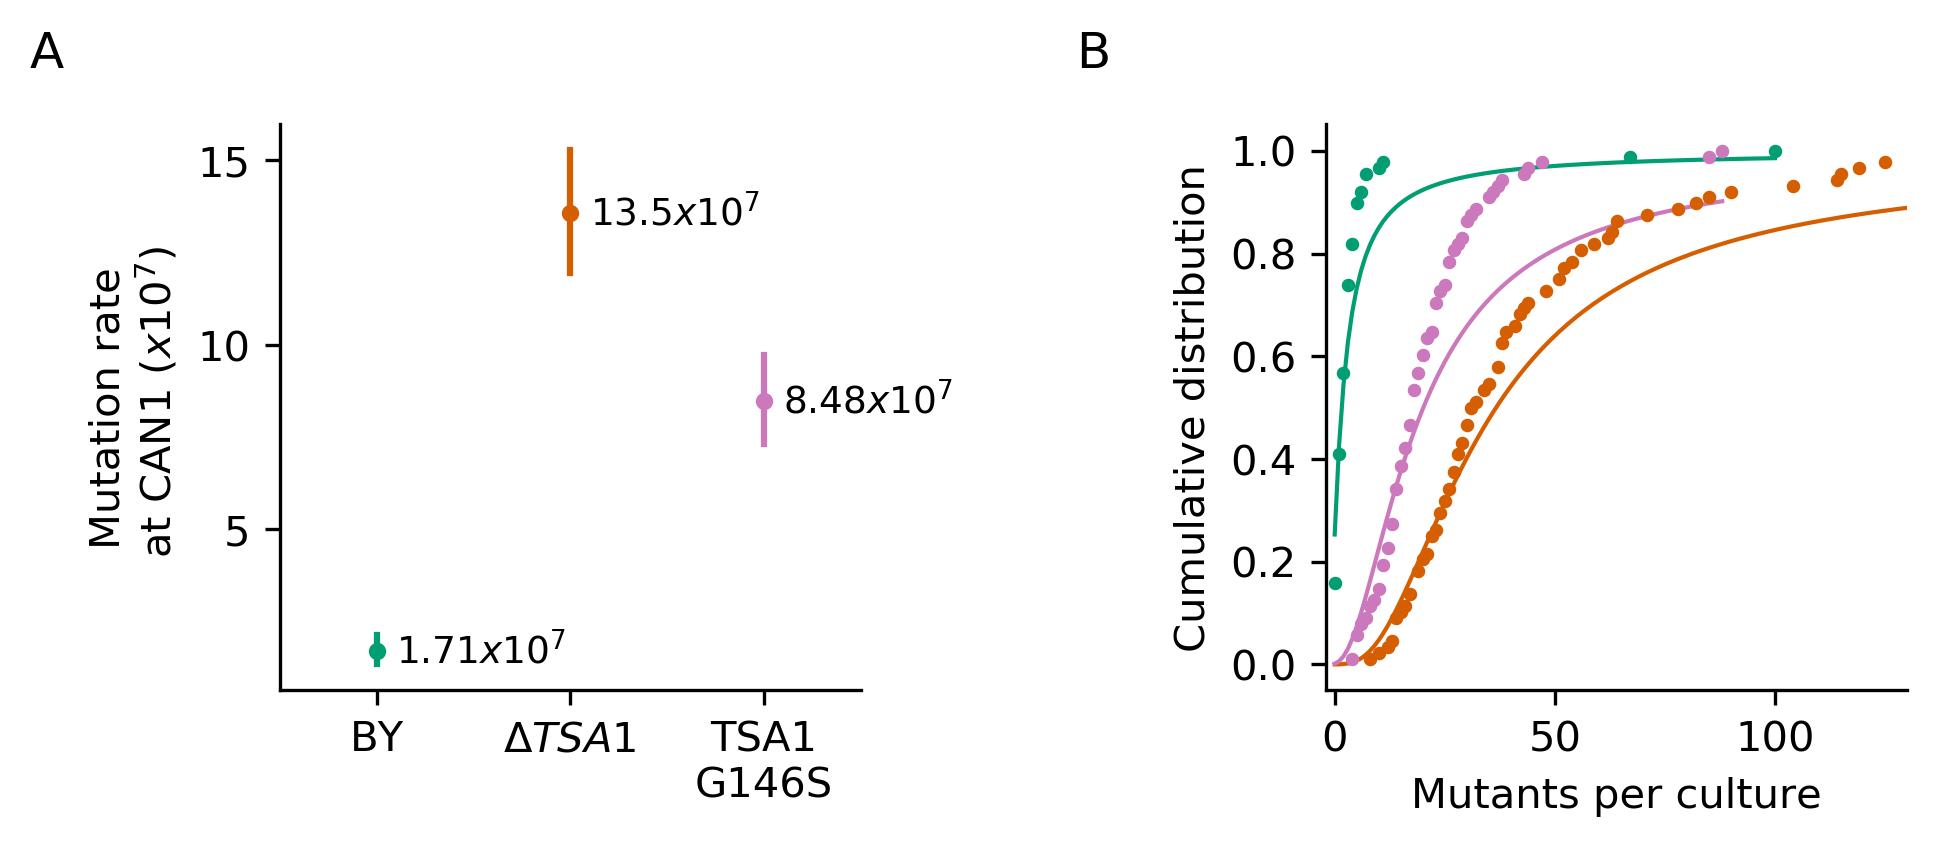

In [5]:
f, subs = pl.subplots(1, 2, figsize=(7,2.5), dpi=300)
pl.subplots_adjust(wspace=0.8)
cells_by_strain = {i[0]:i[1] for i in np.array(td[['Strain', 'Cells']])}
c = 0
strain_formatter = {'BY': 'BY', 'YAN727': '$\Delta TSA1$', 'YAN728': 'TSA1\nG146S'}
mutation_rates = []
for strain in ['BY', 'YAN727', 'YAN728']:
    tmp = list(td[td['Strain']==strain]['Colonies']) # Get colony counts from fluctuation assay
    m = calc_estimated_mutants(tmp) # Estimate mutation rate
    lims = mutation_rate_limits(m, len(tmp), cells_by_strain[strain]) # get 95-conf intervals
    func = cultures_with_mutants_ratio(m) # get luria delbruck function of fitted parameters
    # Get cumulative distribution of colony counts
    counts = 0
    running_counts = []
    possible_vals = sorted(set(tmp))
    for colony_count in possible_vals:
        counts += tmp.count(colony_count)
        running_counts.append(counts/len(tmp))
    # Get fit luria delbruck cumulative distribution
    predictions = []
    counts = 0
    for i in range(np.max(tmp)+1):
        counts += func(i)
        predictions.append(counts)
    # plot distributions
    subs[1].plot([i for i in range(np.max(tmp)+1)], predictions, color=cbs[c+2], lw=1, zorder=-1)
    subs[1].scatter(possible_vals, running_counts, color=cbs[c+2], s=5, zorder=1)
    print(strain, m, m/cells_by_strain[strain], lims)
    mutation_rates.append([strain, m/cells_by_strain[strain], lims[0], lims[1]]) # Record fitted parameters
    c += 1
subs[1].set_xlim([-2,130])

# Plot inferred mutation rates
mut_td = pd.DataFrame(mutation_rates, columns=['Strain', 'u', 'low_95', 'high_95'])
for j, row in mut_td.iterrows():
    subs[0].scatter([j], [row['u']*10000000], color=cbs[j+2], s=10)
    subs[0].annotate(str(row['u']*10000000)[:4]+'$x10^7$', xy=[j+0.1, row['u']*10000000], xycoords="data", va='center', fontsize=9)
    subs[0].plot([j,j], [row['low_95']*10000000, row['high_95']*10000000], color=cbs[j+2])
subs[0].set_xticks([0,1,2])
subs[0].set_xticklabels([strain_formatter[i] for i in mut_td['Strain']])
subs[0].set_xlim([-0.5,2.5])
subs[0].set_ylabel('Mutation rate\n at CAN1 ($x10^7$)')

subs[1].set_xlabel('Mutants per culture')
subs[1].set_ylabel('Cumulative distribution')

subs[0].annotate('A', fontsize=12, xy=(-0.4, 1.1), xycoords="axes fraction", horizontalalignment="center")
subs[1].annotate('B', fontsize=12, xy=(-0.4, 1.1), xycoords="axes fraction", horizontalalignment="center")

sns.despine()

f.savefig('../../Output/Figs/supp_figs/fluctuation_assay.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
f.savefig('../../Output/Figs/supp_figs/fluctuation_assay.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)